In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 3.1. Spark DataFrames & Pandas Plotting - Python

### Create Dataproc Cluster with Jupyter

This notebook is designed to be run on Google Cloud Dataproc.

Follow the links below for instructions on how to create a Dataproc Cluster with the Juypter component installed.

* [Tutorial - Install and run a Jupyter notebook on a Dataproc cluster](https://cloud.google.com/dataproc/docs/tutorials/jupyter-notebook)
* [Blog post - Apache Spark and Jupyter Notebooks made easy with Dataproc component gateway](https://medium.com/google-cloud/apache-spark-and-jupyter-notebooks-made-easy-with-dataproc-component-gateway-fa91d48d6a5a)

### Python 3 Kernel

Use a Python 3 kernel (not PySpark) to allow you to configure the SparkSession in the notebook and include the [spark-bigquery-connector](https://github.com/GoogleCloudDataproc/spark-bigquery-connector) required to use the [BigQuery Storage API](https://cloud.google.com/bigquery/docs/reference/storage).

### Scala Version

Check what version of Scala you are running so you can include the correct spark-bigquery-connector jar 

In [2]:
!scala -version

cat: /release: No such file or directory
Scala code runner version 2.11.12 -- Copyright 2002-2017, LAMP/EPFL


### Create Spark Session

Include the correct version of the spark-bigquery-connector jar

Scala version 2.11 - `'gs://spark-lib/bigquery/spark-bigquery-latest.jar'`.

Scala version 2.12 - `'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar'`.

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
  .appName('Spark DataFrames & Pandas Plotting')\
  .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest.jar') \
  .getOrCreate()

### Enable repl.eagerEval

This will output the results of DataFrames in each step without the new need to show `df.show()` and also improves the formatting of the output

In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

### Read BigQuery table into Spark DataFrame

Use `filter()` to query data from a partitioned table.

In [5]:
table = "bigquery-public-data.wikipedia.pageviews_2020"

df_wiki_pageviews = spark.read \
  .format("bigquery") \
  .option("table", table) \
  .option("filter", "datehour >= '2020-03-01' AND datehour < '2020-03-02'") \
  .load()

df_wiki_pageviews.printSchema()

root
 |-- datehour: timestamp (nullable = true)
 |-- wiki: string (nullable = true)
 |-- title: string (nullable = true)
 |-- views: long (nullable = true)



Select required columns and apply a filter using `where()` which is an alias for `filter()` then cache the table

In [6]:
df_wiki_en = df_wiki_pageviews \
  .select("datehour", "wiki", "views") \
  .where("views > 1000 AND wiki in ('en', 'en.m')") \
  .cache()

df_wiki_en

datehour,wiki,views
2020-03-01 23:00:00,en,3242
2020-03-01 22:00:00,en,2368
2020-03-01 22:00:00,en,2360
2020-03-01 22:00:00,en,2223
2020-03-01 22:00:00,en,1398
2020-03-01 23:00:00,en,1872
2020-03-01 23:00:00,en,136620
2020-03-01 23:00:00,en,1084
2020-03-01 23:00:00,en,1946
2020-03-01 23:00:00,en,8313


Group by title and order by page views to see the top pages

In [7]:
import pyspark.sql.functions as F

df_datehour_totals = df_wiki_en \
.groupBy("datehour") \
.agg(F.sum('views').alias('total_views'))

df_datehour_totals.orderBy('total_views', ascending=False)

datehour,total_views
2020-03-01 21:00:00,1642981
2020-03-01 06:00:00,1591160
2020-03-01 22:00:00,1541455
2020-03-01 17:00:00,1535983
2020-03-01 18:00:00,1495387
2020-03-01 16:00:00,1487786
2020-03-01 05:00:00,1469068
2020-03-01 07:00:00,1458756
2020-03-01 20:00:00,1457051
2020-03-01 15:00:00,1446984


### Convert Spark DataFrame to Pandas DataFrame

Convert the Spark DataFrame to Pandas DataFrame and set the datehour as the index

In [8]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%time pandas_datehour_totals = df_datehour_totals.toPandas()

pandas_datehour_totals.set_index('datehour', inplace=True)
pandas_datehour_totals.head()

CPU times: user 15.8 ms, sys: 4 ms, total: 19.8 ms
Wall time: 3.05 s


,total_views
datehour,
2020-03-01 22:00:00,1541455
2020-03-01 09:00:00,1200977
2020-03-01 12:00:00,1225647
2020-03-01 20:00:00,1457051
2020-03-01 10:00:00,1211310


### Plotting Pandas Dataframe

Import matplotlib

In [9]:
import matplotlib.pyplot as plt

Use the [Pandas plot function](https://pandas.pydata.org/docs/user_guide/visualization.html) to create a line chart

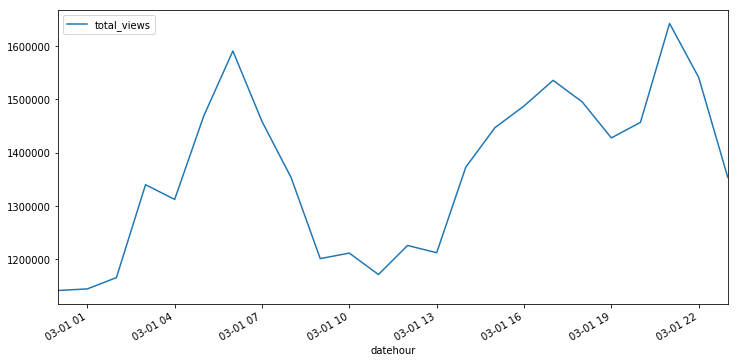

In [10]:
pandas_datehour_totals.plot(kind='line',figsize=(12,6));

### Plot Multiple Columns

Create a new Spark DataFrame and pivot the wiki column to create multiple rows for each wiki value

In [11]:
import pyspark.sql.functions as F

df_wiki_totals = df_wiki_en \
.groupBy("datehour") \
.pivot("wiki") \
.agg(F.sum('views').alias('total_views'))

df_wiki_totals

datehour,en,en.m
2020-03-01 22:00:00,558358,983097
2020-03-01 09:00:00,638692,562285
2020-03-01 12:00:00,633432,592215
2020-03-01 20:00:00,615714,841337
2020-03-01 05:00:00,588808,880260
2020-03-01 10:00:00,644680,566630
2020-03-01 14:00:00,685500,687260
2020-03-01 19:00:00,592967,834844
2020-03-01 03:00:00,391300,948553
2020-03-01 01:00:00,360511,783510


### Convert to Pandas DataFrame

In [12]:
pandas_wiki_totals = df_wiki_totals.toPandas()

pandas_wiki_totals.set_index('datehour', inplace=True)
pandas_wiki_totals.head()

,en,en.m
datehour,,
2020-03-01 22:00:00,558358,983097
2020-03-01 09:00:00,638692,562285
2020-03-01 12:00:00,633432,592215
2020-03-01 20:00:00,615714,841337
2020-03-01 10:00:00,644680,566630


### Create plot with line for each column

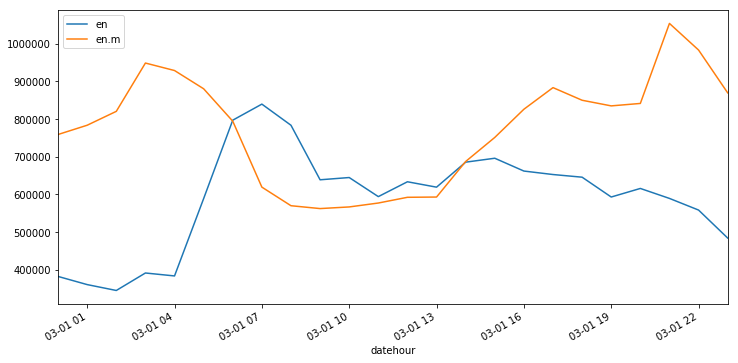

In [13]:
pandas_wiki_totals.plot(kind='line',figsize=(12,6))

### Create stacked area plot 

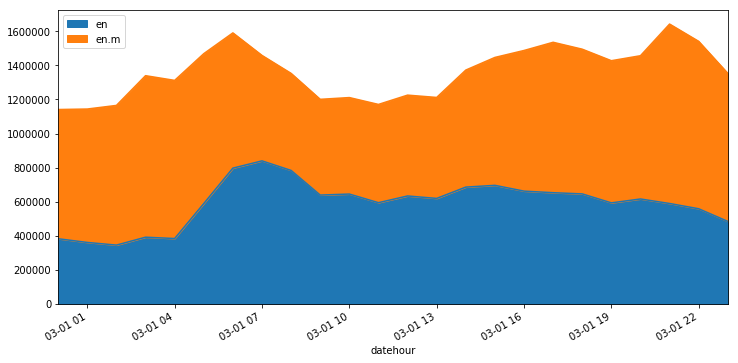

In [14]:
pandas_wiki_totals.plot.area(figsize=(12,6))